In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE
import utils
from social_dynamics.autoencoder_utils import create_dataset

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [ ]:
if "maler" in str(Path(".").resolve()):
    absolute_path = Path("C:/Users/maler/Federico/Lavoro/ZIB/experiments_results") 
elif "luziehel" in str(Path(".").resolve()):
    absolute_path = Path("C:/Users/luziehel/Code/experiments_results")

experiment_series_folder = absolute_path.joinpath("2_opt-h_luzie-gamma_delta_expl")
experiment_series_folder = absolute_path.joinpath("2_opt-h_luzie-alpha_beta_gamma_delta_expl")
experiment_series_folder = absolute_path.joinpath("2_opt-h_luzie-alpha_beta_gamma_delta_expl-0.0001t")

experiment_runs_folders = [folder for folder in experiment_series_folder.iterdir()]

model_type = "dnn"
model_path = Path("C:/Users/maler/Federico/Lavoro/ZIB/autoencoder_clustering/autoencoder_model/model.h5")

In [ ]:
model = tf.keras.models.load_model(model_path)
autoencoder = Model(model.input, model.get_layer('embedding').output)

In [ ]:
folder = np.random.choice(experiment_runs_folders)
state_metric = utils.load_metrics(folder)["StateMetric"][::4]
inputs = state_metric.flatten()
assert np.all(np.reshape(inputs, state_metric.shape) == state_metric)

preds = model.predict(inputs[np.newaxis])

In [ ]:
utils.plot_agents_option(state_metric)

In [ ]:
utils.plot_agents_option(np.reshape(preds, state_metric.shape))

# Random plots

In [ ]:
folders = np.random.choice(experiment_runs_folders, size=10)
state_metrics = [utils.load_metrics(folder)["StateMetric"][::4] for folder in folders]
inputs = np.array([state_metric.flatten() for state_metric in state_metrics])

preds = model.predict(inputs)

n_agents, n_options = state_metrics[0].shape[1:]

plt.figure(figsize=(20, 60))
for i in range(len(state_metrics)):

    for option in range(n_options):
        plt.subplot(n_options*len(state_metrics), 2, 1 + i*4 + option*2)
        for agent in range(n_agents):
            plt.plot(state_metrics[i][:, agent, option], label=str(agent))
            #plt.legend()
            #plt.title("Option "+ str(option+1))
    for option in range(n_options):
        plt.subplot(n_options*len(state_metrics), 2, 2 + i*4 + option*2)
        for agent in range(n_agents):
            to_plot = np.reshape(preds[i], state_metrics[0].shape)
            plt.plot(to_plot[:, agent, option], label=str(agent))

plt.tight_layout()


plt.show()

# Worse prediction plots

In [ ]:
dataset = create_dataset(experiment_series_folder, model_type=model_type, downsampling=4, cut=False)
file_pattern = str(experiment_series_folder) + "/*/StateMetric/results_t200000.npy"
file_dataset = tf.data.Dataset.list_files(file_pattern=file_pattern, shuffle=False)

In [ ]:
y_preds = model.predict(dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE))
y_true = np.array(list(dataset.as_numpy_iterator()))[:, 1, :]
mses = MSE(y_true, y_preds)

worse_preds = np.argsort(mses)[-100:]
worse_files = np.array(list(file_dataset.as_numpy_iterator()))[worse_preds]

In [ ]:
files = np.random.choice(worse_files, size=10)
state_metrics = [np.load(file)[::4] for file in files]
inputs = np.array([state_metric.flatten() for state_metric in state_metrics])

preds = model.predict(inputs)

n_agents, n_options = state_metrics[0].shape[1:]

plt.figure(figsize=(20, 60))
for i in range(len(state_metrics)):

    for option in range(n_options):
        plt.subplot(n_options*len(state_metrics), 2, 1 + i*4 + option*2)
        for agent in range(n_agents):
            plt.plot(state_metrics[i][:, agent, option], label=str(agent))
            #plt.legend()
            #plt.title("Option "+ str(option+1))
    for option in range(n_options):
        plt.subplot(n_options*len(state_metrics), 2, 2 + i*4 + option*2)
        for agent in range(n_agents):
            to_plot = np.reshape(preds[i], state_metrics[0].shape)
            plt.plot(to_plot[:, agent, option], label=str(agent))

plt.tight_layout()


plt.show()

# MSE distribution

In [ ]:
dataset = create_dataset(experiment_series_folder, model_type=model_type, downsampling=4, cut=False)

print("created dataset")
y_preds = model.predict(dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE))
print("predicted")
y_true = np.array(list(dataset.as_numpy_iterator()))[:, 1, :]
mses = MSE(y_true, y_preds).numpy()


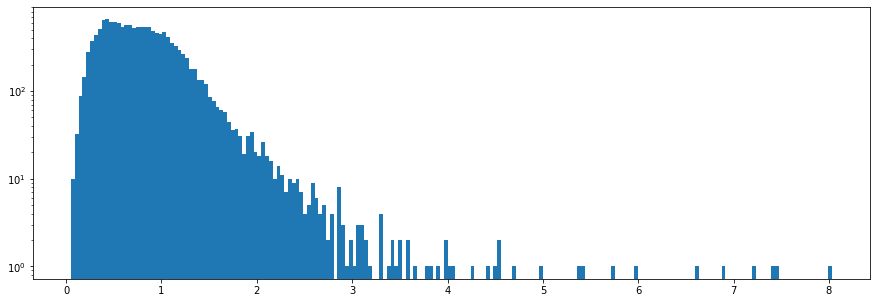

In [8]:
plt.figure(figsize=(15, 5))
plt.hist(mses, bins=200)
plt.yscale("log")
plt.show()

# Autoencoder n_params distribution

In [3]:
model_path = Path("C:/Users/maler/Federico/Lavoro/ZIB/autoencoder_clustering/")

model_input_types = ["cnn-complete", "cnn-cut", "dnn-complete", "dnn-cut"]

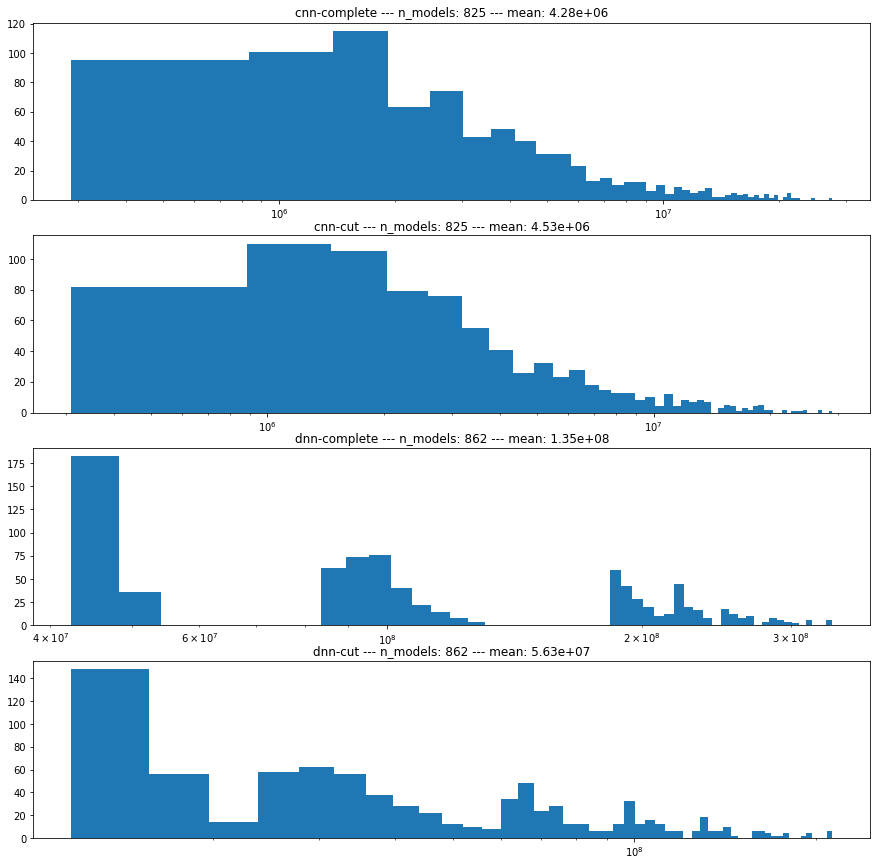

In [4]:
plt.figure(figsize=(15, 15))
for i, model_input_type in enumerate(model_input_types):
    plt.subplot(4, 1, i+1)
    n_params_dist = np.load(model_path.joinpath(model_input_type + ".npy"))
    plt.hist(n_params_dist, bins=50)
    plt.xscale("log")
    plt.title("{} --- n_models: {} --- mean: {}".format(model_input_type, n_params_dist.shape[0], format(np.mean(n_params_dist), "3.2e")))
plt.show()
